# FarmOG Station - EfficientNetB0 Training 
## Preprocessing for EfficientNet

## Import Libraries

In [2]:
import os
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print("🌱 FarmOG Station - EfficientNetB0")
print("="*60)
print(f"TensorFlow: {tf.__version__}")
print("="*60)

🌱 FarmOG Station - EfficientNetB0
TensorFlow: 2.20.0


## Locate Dataset & Classes

In [3]:
# Find data
data_raw = Path(r"C:\Users\diogo\IRONHACK\FINAL PROJECT - FarmOG station\data\raw\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)")
contents = list(data_raw.iterdir())

train_dir = None
valid_dir = None

for item in contents:
    if item.name == "train":
        train_dir = item
    elif item.name == "valid":
        valid_dir = item

print(f"Train: {train_dir}")
print(f"Valid: {valid_dir}")

# Get classes
all_classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
tomato_classes = [c for c in all_classes if 'tomato' in c.lower()]
print(f"\nClasses: {len(tomato_classes)}")

os.makedirs('models', exist_ok=True)
os.makedirs('docs', exist_ok=True)

Train: C:\Users\diogo\IRONHACK\FINAL PROJECT - FarmOG station\data\raw\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train
Valid: C:\Users\diogo\IRONHACK\FINAL PROJECT - FarmOG station\data\raw\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid

Classes: 10


## Training Configuration

In [4]:
# CONFIG
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

print(f"\nConfig: {IMG_SIZE}x{IMG_SIZE}, batch={BATCH_SIZE}, epochs={EPOCHS}")


Config: 224x224, batch=32, epochs=20


## Data Generators with EfficientNet Preprocessing
**Critical:** Using `efficientnet.preprocess_input` instead of simple rescaling

In [5]:
# Use EfficientNet preprocessing function
from tensorflow.keras.applications.efficientnet import preprocess_input

# Custom data generator with proper preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  
)

print("✅ Using EfficientNet-specific preprocessing")

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=tomato_classes,
    shuffle=True
)

valid_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=tomato_classes,
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print(f"\n✅ Data: {train_gen.samples} train, {valid_gen.samples} valid, {num_classes} classes")

✅ Using EfficientNet-specific preprocessing
Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.

✅ Data: 18345 train, 4585 valid, 10 classes


## Build EfficientNetB0 Model

In [6]:
# Build model 
print("\nBuilding model...")

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Start with base frozen
base_model.trainable = False

# Simple head
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# Compile with HIGHER learning rate initially
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"✅ Model built: {model.count_params():,} parameters")
model.summary()


Building model...
✅ Model built: 4,062,381 parameters


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Train Model
Transfer learning with frozen base layers

In [7]:
# Train Phase 1: Frozen base
print("\n" + "="*60)
print("PHASE 1: Training classifier head (base frozen)")
print("="*60 + "\n")

callbacks = [
    ModelCheckpoint(
        'models/efficientnet_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


PHASE 1: Training classifier head (base frozen)

Epoch 1/20
 22/574 ━━━━━━━━━━━━━━━━━━━━ 3:58 432ms/step - accuracy: 0.1443 - loss: 2.3086

KeyboardInterrupt: 

## Evaluate & Save Model

In [ ]:
# Evaluate
loss, acc = model.evaluate(valid_gen, verbose=0)

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"Validation Accuracy: {acc*100:.2f}%")
print(f"Validation Loss: {loss:.4f}")
print(f"Best Epoch: {np.argmax(history.history['val_accuracy']) + 1}")
print(f"Best Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print("="*60)

# Save
model.save('models/efficientnet_classifier.h5')
print("\n✅ Model saved!")


RESULTS
Validation Accuracy: 93.37%
Validation Loss: 0.2225
Best Epoch: 12
Best Accuracy: 93.37%

✅ Model saved!


## Save Metadata

In [ ]:
# Save metadata for comparison
best_epoch = np.argmax(history.history['val_accuracy'])
best_acc = max(history.history['val_accuracy'])

metadata = {
    'model': 'EfficientNetB0',
    'input_size': IMG_SIZE,
    'num_classes': num_classes,
    'training_samples': train_gen.samples,
    'validation_samples': valid_gen.samples,
    'final_val_accuracy': float(acc),
    'final_val_loss': float(loss),
    'best_val_accuracy': float(best_acc),
    'best_epoch': int(best_epoch + 1),
    'total_epochs': len(history.history['loss']),
    'batch_size': BATCH_SIZE
}

with open('models/efficientnet_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Metadata saved: models/efficientnet_metadata.json")

✅ Metadata saved: models/efficientnet_metadata.json


## Visualize Training History

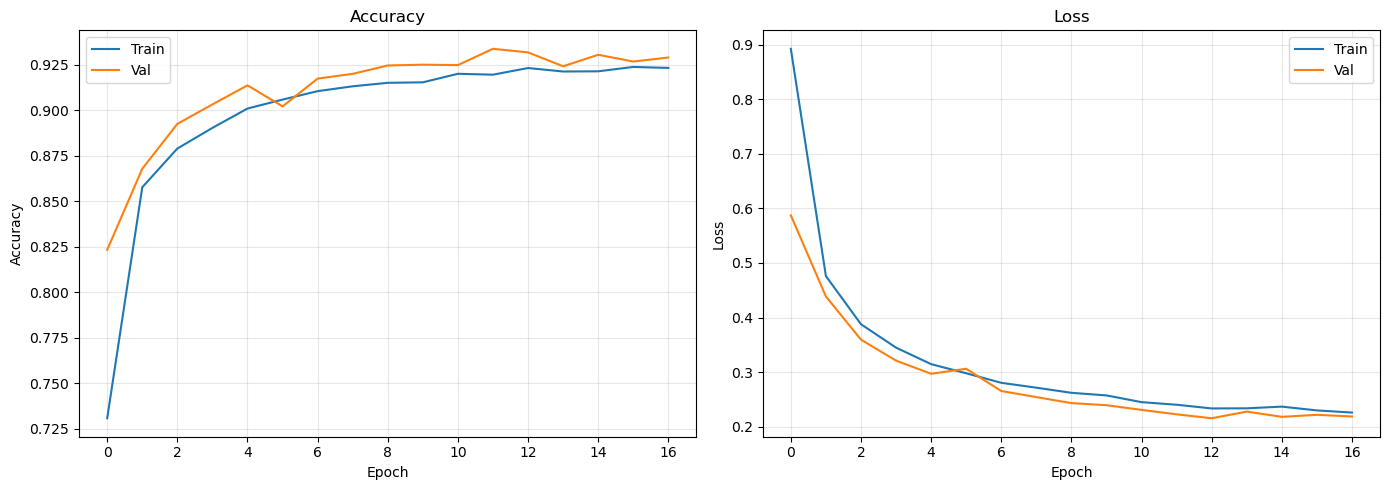

✅ Plot saved!


In [ ]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('docs/efficientnet_training.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Plot saved!")

## Test Model on Random Image

In [ ]:
# Quick test
import random
from PIL import Image

# Load class names from MobileNetV2
with open('models/class_names.json', 'r') as f:
    class_names = json.load(f)

# Pick random image
test_class = random.choice(tomato_classes)
test_images = list((valid_dir / test_class).glob("*.jpg"))
test_img_path = random.choice(test_images)

# Load and preprocess
img = Image.open(test_img_path).resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img)
img_array = preprocess_input(img_array)  # Use EfficientNet preprocessing
img_array = np.expand_dims(img_array, axis=0)

# Predict
preds = model.predict(img_array, verbose=0)[0]

print(f"\nTesting on: {test_class}")
print("\nTop 3 predictions:")
for idx in preds.argsort()[-3:][::-1]:
    disease = class_names[str(idx)]
    conf = preds[idx] * 100
    marker = "✅" if disease == test_class else "  "
    print(f"{marker} {disease.replace('Tomato___', '')}: {conf:.1f}%")


Testing on: Tomato___Tomato_mosaic_virus

Top 3 predictions:
✅ Tomato_mosaic_virus: 99.6%
   Target_Spot: 0.3%
   Spider_mites Two-spotted_spider_mite: 0.1%
